In [15]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from glob import glob
from multiprocessing import cpu_count
from multiprocessing import Pool

# custom functions for multiprocessing
from read_csv import read_csv
from get_DBSCAN_mask import get_DBSCAN_mask

In [16]:
def get_span(df0):
    """
    Get span for cropping scan based on highest point (Z-data)
    within profile in the middle of scan. 
    Get y-value of zMax at the profile in the middle of the scan. 
    Use yMean to adjust y-values. Put zMax at y=0.
    Only works if there is one wall visible in the scan.
    
    Parameters
    ----------
    df0 : DataFrame
    data of first layer
    
    Returns
    -------
    span : range
        range of integers within the borders
    yMean: float
        y at zMax
    """

    # load data
    r = df0.shape[0] # rows
    dfy, _, dfz = df0[:int(1/3*r)],df0[int(1/3*r):int(2/3*r)],df0[int(2/3*r):]
    dfz = dfz.reset_index(drop=True)

    # one row of z data from middle of scan in xDir
    dfy_row = dfy.iloc[int(1/2*dfy.shape[0]),:]
    dfz_row = dfz.iloc[int(1/2*dfz.shape[0]),:]

    # remove empty strings ''
    dfy_row = dfy_row.replace('', np.nan, regex=True).dropna()
    dfz_row = dfz_row.replace('', np.nan, regex=True).dropna()

    # restrict search for max(z) to middle of scan in yDir
    dfz_row = dfz_row[240:1041] # middle = 640

    # get index of max(z)
    max_id = dfz_row.astype('float').idxmax(axis=0)

    ########################################################
    # get span arround highest point
    width = 200
    b0 = max_id - width # lower border index
    b1 = max_id + width # upper border index
    span = range(b0,b1)

    # get yMean at max(z)
    yMean = float(dfy_row[max_id])

    return span, yMean

In [17]:
def df2float(df_in,n):
    """
    Replace empty strings with NaN and convert strings to float

    Parameters
    ----------
    df_in : DataFrame
        data from read_csv
    n : int
        drop rows with more than n NaN values

    Returns
    -------
    df : DataFrame
        dataFrame with NaN and values dtype = 'float'
    """

    # drop rows with more than n NaN values
    df = df_in.dropna(thresh=df_in.shape[1]-n)
    
    try:
        df = df.replace('', np.nan, regex=True) # replace empty string with NaN
    except:
        print('no NaN detected')
    finally:
        df = df.astype('float')
        df = df.reset_index(drop=True)
    return df

In [18]:
def rot_y(dfx_in, dfz_in, angle_max):
    """
    Make baseplate parallel to x-axis.
    x-values are not adjusted after rotation to make slices with unique x-values remain.
    How it works:
    delta_x and delta_z form the a and b sides of a triangle with a 90° in between a and b.
    Due to the banana-shaped baseplate the angle is calculated from the middle.
    Therefore two angles are calculated. 
    Single outlier points (especially at the start/end of the data) may affect the 
    calculation of the correct angle. 
    Therefore the angle is calculated for EVERY POINT. The final angle is the median of all
    calculated angles which improves the stability of the algorithm without significantly 
    affecting total computation time.
    
    Parameters
    ----------
    dfx : DataFrame
        x-values
    dfx : DataFrame
        z-values
    angle_max: float
        angle in degrees, must be positive number
        straightening is applied when alpha > max. angle
        
    Returns
    -------
    dfz : DataFrame
        dataFrame of z-values (with adjusted z-values)
    """
    
    # convert to numpy because indexing is a pain
    X = dfx_in.to_numpy()
    Z = dfz_in.to_numpy()

    # get average angle of base plate
    m = int(dfx_in.shape[0]/2)    # middle of rows
    a1 = X[m, 1] - X[:m, 1]       # All adjacents (Alle Ankatheten), middle to start
    b1 = Z[m, 1] - Z[:m, 1]       # All Opposite legs (Alle Gegenkatheten), delta_z   
    a2 = X[-1:m:-1, 1] - X[m, 1]  # delta_x: end to middle
    b2 = Z[-1:m:-1, 1] - Z[m, 1]  # delta_z
    c1 = np.sqrt(np.square(a1) + np.square(b1)) # hypotenuses of triangles
    c2 = np.sqrt(np.square(a2) + np.square(b2))
    beta_rad1 = np.arcsin(b1/c1)
    beta_rad2 = np.arcsin(b2/c2)
    beta = np.median(np.concatenate((beta_rad1,beta_rad2),axis=0)) # average angle
    
    # rotate points arround y-axis
    if np.abs(np.rad2deg(beta)) > angle_max:
        c,s = np.cos(beta),np.sin(beta)
        arr = Z*c - X*s # Apply the rotation to z coordinate only
        dfz = pd.DataFrame(arr, index=dfz_in.index, columns=dfz_in.columns)
        print('rot_y angle = ' + str(np.round(np.rad2deg(beta),3)) + '°')
    else: 
        dfz = dfz_in
   
    return dfz

In [19]:
def rot_x(dfy_in, dfz_in, angle_max):
    """
    Make baseplate parallel to y-axis.
    Rotate arround x-axis. 
    Made for V12 layer 02
    
    Parameters
    ----------
    dfx : DataFrame
        x-values
    dfx : DataFrame
        z-values
    angle_max: float
        angle in degrees, must be positive number
        straightening is applied when alpha > max. angle
        
    Returns
    -------
    dfz : DataFrame
        dataFrame of z-values (with adjusted z-values)
    """
    
    # convert to numpy because indexing is a pain
    Y = dfy_in.to_numpy()
    Z = dfz_in.to_numpy()

    # get average angle of base plate
    a = Y[0, 1] - Y[0, -1] # dfy = [id=3074,12,11,... -11,-12]
    b = Z[0, 1] - Z[0, -1] # dfz = [id=3074,0.3,1.4,...,11.2,12.5]
    c = np.sqrt(np.square(a) + np.square(b)) # hypotenuse of triangle
    alpha = np.arcsin(b/c) # average angle [rad]

    # rotate points arround y-axis
    if np.abs(np.rad2deg(alpha)) > angle_max:
        c,s = np.cos(alpha),np.sin(alpha)
        arr = Z*c - Y*s # Apply the rotation to z coordinate only
        dfz = pd.DataFrame(arr, index=dfz_in.index, columns=dfz_in.columns)
        print('rot_x angle = ' + str(np.round(np.rad2deg(alpha),3)) + '°')
    else:
        dfz = dfz_in

    return dfz

In [20]:
def get_z_baseplate(dfz_in):
    """
    z-value of baseplate. Use it to make z(base plate) = 0.

    Parameters
    ----------
    dfz : DataFrame
        data after df2float

    Returns
    -------
    zBP : float
        min. z-value of baseplate
    """

    # set low values to NaN, low values typically exist in flawed scans
    dfz = dfz_in.copy()

    # Get the first and last columns
    first_column = dfz.iloc[:,1] # [:,1] to omit index column
    last_column = dfz.iloc[:,-1]

    # Sort both columns separately in ascending order
    sorted_first_column = first_column.sort_values()
    sorted_last_column = last_column.sort_values()

    # Take the last 10 rows from each sorted column
    # (which will give you the 10 biggest values)
    n = 10
    biggest_10_first_column = sorted_first_column.iloc[-n:]
    biggest_10_last_column = sorted_last_column.iloc[-n:]

    # Calculate the median of the 10 smallest values in each column
    median_of_biggest_first_column = np.median(biggest_10_first_column)
    median_of_biggest_last_column = np.median(biggest_10_last_column)

    z_baseplate = max(median_of_biggest_first_column,median_of_biggest_last_column)

    return z_baseplate

In [21]:
def get_x0(dfx,dfz,z_min):
    """
    X coordinates of different scans do not overlap due to 
    manual starting/stopping of scans. 
    Every weld after the first weld contains at least the height 
    of the first weld.
    Notice: The data from start of scan is used because there is insufficient data 
    at the end of a wall due to laser scanning triangulation method. 
        
    Parameters
    ----------
    dfx: dataframe
        x-data, shape (N,400)
    dfz: dataframe
        x-data, shape (N,400)
    z_min: float
        min. height for detection of weld
    
    Returns
    -------
    x0: float
        x-coordinate at which the wall reaches a critical height z=1 mm
    """

    # Get the average values of the first quarter of scan profiles
    r = dfz.shape[0] # rows
    z_mean = dfz.iloc[:int(1/4*r)].mean() # column means

    # Get the index of the column with the highest average value
    index_z_max = z_mean.idxmax()

    # get x and z data for col with z_max
    x = dfx[index_z_max].to_numpy() 
    z = dfz[index_z_max].to_numpy() # column_747 = dfz[747]

    # find x-coordinate of start-hump/end-hump in data
    indices = np.concatenate(np.where(z > z_min)).reshape(-1)
    
    # start of wall
    x0 = x[indices[0]]

    # # plot
    # x1 = x[indices[-1]] # end of wall
    # z0 = z[indices[0]]
    # z1 = z[indices[-1]]
    # fig, ax = plt.subplots(figsize=(4.24,3))
    # ax.scatter(x,z,marker='.')
    # ax.scatter(x0,z0,marker='.',c='red') # start of wall
    # ax.scatter(x1,z1,marker='.',c='orange') # end of wall
    # plt.show()

    # print('y = '+ str(dfy.iloc[1,200]))
    # print('x0 = '+str(x0))
    # # plot scan at x0 - TESTING
    # fig, ax = plt.subplots(figsize=(4.24,3))
    # ax.scatter(dfy.iloc[indices[0],1:].to_numpy(),
    #            dfz.iloc[indices[0],1:].to_numpy(),
    #            marker='.')
    # plt.show()

    return x0

In [22]:
def get_layer_00(df):
    """
    Create a layer_00 based on a surface fit of layer_01 (without weld bead)
    Take layer_01 and get z-data based on the surface fit.

    Parameters
    ----------
    df: dataframe
        dataFrame of layer_01 after all coordinate adjustments 
        but before filtering out any points (baseplate data requiered) 
    
    Returns
    -------
    arr0: ndarray
        array of shape (n,3)
        x and y from layer_01
        z data from surface fit of baseplate in layer_01
    """

    # load data
    r = df.shape[0] # rows
    x0 = df[int(1/3*r):int(2/3*r)].to_numpy()
    y0 = df[:int(1/3*r)].to_numpy()
    z0 = df[int(2/3*r):].to_numpy()

    # get points from edges
    n = 50 # number of columns from edges for surca fit
    x_edge = np.concatenate((x0[:,:n],x0[:,-n:]),axis=1).flatten() #1-D-Data
    y_edge = np.concatenate((y0[:,:n],y0[:,-n:]),axis=1).flatten()
    z_edge = np.concatenate((z0[:,:n],z0[:,-n:]),axis=1).flatten()

    # get random data sample for fast surface fit
    dfs = pd.DataFrame({'X':x_edge,'Y':y_edge,'Z':z_edge})
    dfs = dfs.sample(frac=0.01)
    x,y,z = dfs.X,dfs.Y,dfs.Z

    # Generate polynomial features up to degree 2
    poly = PolynomialFeatures(degree=2)
    xy_poly = poly.fit_transform(np.column_stack((x, y)))

    # Fit a linear regression model to the polynomial features
    model = LinearRegression()
    model.fit(xy_poly, z)

    # Evaluate the fitted surface on a grid
    xy_fit = poly.fit_transform(np.column_stack((x0.ravel(), y0.ravel())))
    z_fit = model.predict(xy_fit) #.reshape(X.shape)

    # combine x0,y0 and z_fit to layer_00
    arr0 = np.column_stack((x0.ravel(),y0.ravel(),z_fit))

    # Plot the data and the fitted surface
    # fig = plt.figure(figsize=(2*4.24,2*3))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x, y, z, c='b', marker='o')
    # ax.scatter(x0, y0, z_fit, c='k', marker='.')
    # plt.show()


    return arr0

In [23]:
def in_max_height(dfz_in,hMax):
    """
    Replace z-values smaller than zMax - hMax with NaN.

    Parameters
    ----------
    dfz : DataFrame
        z-values
    hMax : float
        max. allowed height of layer

    Returns
    -------
    dfz : DataFrame
        dataFrame of z-values with NaN for z-values < zMax - hMax
    """
    dfz = dfz_in.copy()
    
    # Find the maximum z-value in each row
    max_values = dfz.iloc[:,1:].max(axis=1)

    # Set z < max_values - hMax to NaN
    dfz[dfz < max_values.values[:, None] - hMax] = np.nan
    
    return dfz

In [24]:
def df2array(df):
    """
    Return the X,Y,Z as one array A with three columns.
    Delete NaN from arrays

    Parameters
    ----------
    df : DataFrame
        data from read_csv

    Returns
    -------
    A : ndarray
        1D-arrays containing data of laserscan
    """

    r = df.shape[0] # rows
    dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]
    dfx = dfx.reset_index(drop=True)
    dfz = dfz.reset_index(drop=True)
    
    # convert to 2D numpy array
    X2 = dfx.to_numpy()[:,1:] # [:,1:] to ignore index col
    Y2 = dfy.to_numpy()[:,1:]
    Z2 = dfz.to_numpy()[:,1:]

    # make 1D array
    X,Y,Z = X2.flatten(),Y2.flatten(),Z2.flatten()

    # delete all points with NaN values
    mask = ~np.isnan(Z)
    X,Y,Z = X[mask],Y[mask],Z[mask]

    # sort array for plot and np.gradient
    X,Y,Z = zip(*sorted(zip(X,Y,Z)))
    X,Y,Z = np.array(X),np.array(Y),np.array(Z)

    # Stack the arrays horizontally to create an array of shape(n,3) 
    A = np.column_stack((X, Y, Z))

    return A

In [25]:
def clustering_multiprocess(A):
    """
    Apply DBSCAN to every slice of point cloud.
    Get the weld surface.

    Parameters
    ----------
    A : ndarray
        array of shape (N,3) 
        point cloud before clustering filter

    Returns
    -------
    A_filtered : ndarray
        array of shape (N,3) 
        point cloud after clustering filter
    """

    # transform to dataFrame for groupby-function
    df = pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2]})

    # Group the data by unique values in the 'X' column
    grouped = df.groupby('X')

    # process the dataFrames in 'grouped' in parallel
    with Pool(processes=cpu_count()) as pool:
        mask_list = pool.map(get_DBSCAN_mask,[group_df for _, group_df in grouped])

    # make mask for A from masks of slices
    mask = np.concatenate(mask_list)
    
    return A[mask]

In [26]:
def remove_duplicates(A,A0,min_distance):
    """
    Filter out points that are in previous layer.
    Good overlap of layers is esential for this function!

    Parameters
    ----------
    A : ndarray
        array of shape (N,3) 
        point cloud of current layer
    A0 : ndarray
        array of shape (N,3) 
        point cloud of previous layer
    min_distance: float
        mininum distance between old and new layer
        
    Returns
    -------
    A[mask] : ndarray
        array of shape (N,3) 
        point cloud without points from previous layer.
    """

    # min_distance = 0.2
    tree = cKDTree(A0)  # Build the kd-tree for array A0
    distances, _ = tree.query(A, k=1)  # Find the nearest neighbor in A for each point in A0
    mask = distances >= min_distance  # Create a boolean mask for points with distance >= min
    return A[mask]  # Filter out points from A using the mask

# load data

In [27]:
if __name__ ==  '__main__':
    ########## IMPORT DATA ##########
    # MANUAL INPUT: set specimen Nr
    VNr = 12-1 # Example: VNr=0 --> V01

    # get time for performance monitoring 
    t0 = time.time()

    # Get a list of all files and folders within the data directory
    main_dir = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze"
    data_dir = main_dir + '\data'
    folders = [folder for folder in os.listdir(data_dir) 
            if os.path.isdir(os.path.join(data_dir, folder))] # only folders

    # get list of CSV files 
    spec_dir = data_dir + "\\" + folders[VNr]
    csv_files = glob(os.path.join(spec_dir, "*.csv"))
    # csv_files = [csv_files[0],csv_files[1],csv_files[2]] # selection
    
    # process the CSV files in parallel
    with Pool(processes=cpu_count()) as pool: 
        df_read = pool.map(read_csv, csv_files)
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

    ########## PREPARE DATA ##########
    # get span for cropping dataFrames 
    span,yMean_at_zMax = get_span(df_read[0])

    # Generate paths to npy-files
    npy_paths = []
    for i in range(0,len(csv_files)+1): # Loop from 0 to 15 (inclusive)
        file_name = f'layer_{i:02d}.npy' # Format file name with leading zeros for single-digit numbers
        npy_paths.append(spec_dir + '\\' + file_name)

read finished after: 10.4 s


# processing loop

1/3
removed duplicates after: 6.5 s
saving C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V12\layer_01.npy
layer finished after: 14.8 s


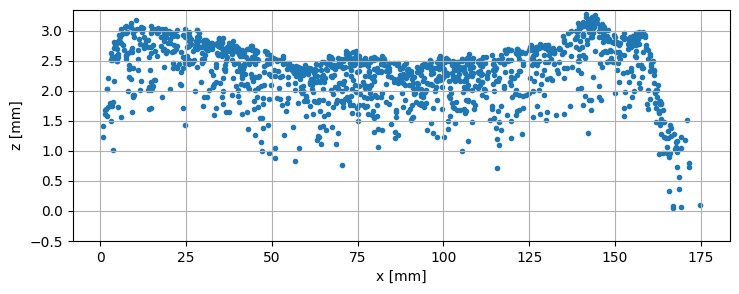

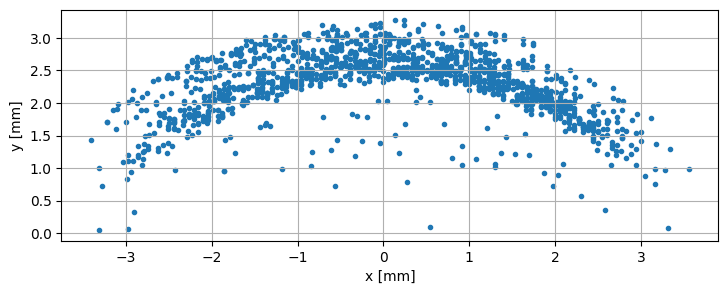

9/3
Warning! Start wrong! Change value MANUALLY if this error occurs!
removed duplicates after: 14.4 s


IndexError: list index out of range

In [28]:
if __name__ == '__main__':
    for ii,layer_file in enumerate(csv_files):
        # print progress
        t1 = time.time()
        i = int(layer_file[-6:-4]) # i=ii+1, if all files used, useful for selections
        print(str(i) + '/' + str(len(csv_files)))

        # copy, crop, convert to float
        df = df_read[ii].copy()
        df = df.iloc[:,span]
        df = df2float(df,5)

        ########## ADJUST COORDINATES ##########
        # scan settings
        v = [150,150,150,150,249,249,249,249,174,174,174,174,150,249,174,174,174] # mm/min
        vs = 5 # scanControl speed setting in [mm/s]

        # split dataFrame
        r = df.shape[0] # rows
        dfy, dfx, dfz = df[:int(1/3*r)],df[int(1/3*r):int(2/3*r)],df[int(2/3*r):]

        # adjust
        dfz = rot_y(dfx,dfz,angle_max=0.5)   # z - rotate arround y-axis if baseplate crooked
        dfz = rot_x(dfy,dfz,angle_max=5)     # z - rotate arround x-axis if baseplate crooked
        dfy -= yMean_at_zMax                 # y - move middle to y=0
        dfz -= get_z_baseplate(dfz)          # z - make z(baseplate)=0 at x=0
        dfx = dfx.multiply(v[VNr]/(vs*60))   # x - scaling
        if i==9: # V12 layer_09
            dfx = dfx - get_x0(dfx,dfz,z_min=0.5) + 20.3 # x - overlay two layers
            print('Warning! Start wrong! Change value MANUALLY if this error occurs!')
        else:
            dfx -= get_x0(dfx,dfz,z_min=0.5) # x - overlay two layers

        # put subDataFrames back into df (this should happen automatically, but doesn't work)
        df[int(1/3*r):int(2/3*r)] = dfx
        df[:int(1/3*r)] = dfy
        df[int(2/3*r):] = dfz

        # plot with baseplate
        if i==15: #V12 layer_15
            print('scatter plot with baseplate, look for error causes!')
            A = df2array(df)
            dfp=pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2]})
            dfp = dfp.sample(frac=0.01)
            fig, ax = plt.subplots(figsize=(2*4.24,3))
            ax.scatter(dfp.X,dfp.Z,marker='.')
            ax.set_xlabel('x [mm]')
            ax.set_ylabel('z [mm]')
            plt.grid(True)
            plt.show()

            # plot y-z-data (cross-section)
            fig, ax = plt.subplots(figsize=(2*4.24,3))
            ax.scatter(dfp.Y,dfp.Z,marker='.')
            ax.set_xlabel('x [mm]')
            ax.set_ylabel('y [mm]')
            plt.grid(True)
            plt.show()


        # Create layer00.npy
        if i==1: np.save(npy_paths[0], get_layer_00(df))

        ########## FILTER ##########
        dfz = in_max_height(dfz,hMax=5) # get all points in allowed max. layer height
        df[int(2/3*r):] = dfz

        ########## REMOVE SIMILAR POINTS ##########
        A = df2array(df)
        A = A[A[:,2]>0] # remove low points

        # load all previous layers
        A_prev = []
        for npy_path in npy_paths[:i]: A_prev.append(np.load(npy_path))

        # remove duplicate points
        A = remove_duplicates(A,A0=np.concatenate(A_prev,axis=0),min_distance=0.2)
        print('removed duplicates after: ' + str(np.round(time.time()-t1, 1)) + ' s')

        ########## CLUSTER POINTS ##########
        # Cluster points and remove points outside of weld surface
        C = clustering_multiprocess(A)

        ########## SAVE POINTS TO A FILE ############
        print('saving ' + npy_paths[i])
        np.save(npy_paths[i],C)
        print('layer finished after: ' + str(np.round(time.time()-t1, 1)) + ' s')

        ########## PLOT ##########
        # plot x-z-data 
        dfp=pd.DataFrame({'X':C[:,0],'Y':C[:,1],'Z':C[:,2]})
        dfp = dfp.sample(frac=0.01)
        fig, ax = plt.subplots(figsize=(2*4.24,3))
        ax.scatter(dfp.X,dfp.Z,marker='.')
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('z [mm]')
        ax.set_ylim([-0.5,np.max(C[:,2])])
        plt.grid(True)
        plt.show()

        # plot y-z-data (cross-section)
        fig, ax = plt.subplots(figsize=(2*4.24,3))
        ax.scatter(dfp.Y,dfp.Z,marker='.')
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')
        plt.grid(True)
        plt.show()
